Partially moved to snakemake.

In [6]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.auto import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
%load_ext autoreload
%autoreload 2
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

from pathlib import Path
figure_path = Path('../figures/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def simul(mu=(2,-2), S=(5,3), D=30, N=1000, iterations=50, correction_factor=True, pca=False, do_zscore=True):
    from itertools import product
    D = [D] if type(D) is int else D
    N = [N] if type(N) is int else N
    evals = [x for x in product(D, N)]
    res = []
    for d, n in tqdm(evals):
        factor = (n/(n-1)) if correction_factor else 1
        for i in range(iterations):
            X = np.random.normal(mu[0], S[0], size=(n, d))
            Y = np.random.normal(mu[1], S[1], size=(n, d))
            if pca:
                from sklearn.decomposition import PCA
                from scipy.stats import zscore
                pca = PCA(n_components=np.min([n, 30]))
                XY = np.vstack([X,Y])
                Z = zscore(XY, axis=0) if do_zscore else XY
                pca.fit(Z)
                X = pca.transform(X)
                Y = pca.transform(Y)
            dxy = np.mean(pairwise_distances(X,Y, metric='sqeuclidean'))
            sx = np.mean(pairwise_distances(X,X, metric='sqeuclidean'))*factor
            sy = np.mean(pairwise_distances(Y,Y, metric='sqeuclidean'))*factor
            ed = 2*dxy-sx-sy
            res.append([ed, dxy, sx, sy, i, d, n])
    return pd.DataFrame(res, columns=['edistance', 'delta', 'sigma_x', 'sigma_y', 'iteration', 'dimension', 'sample_size'])

# Dimension has no impact

In [8]:
df = simul(mu=(2,-2), S=(5,3), D=np.arange(1,21), N=100, iterations=50)

100%|██████████| 20/20 [00:00<00:00, 31.45it/s]


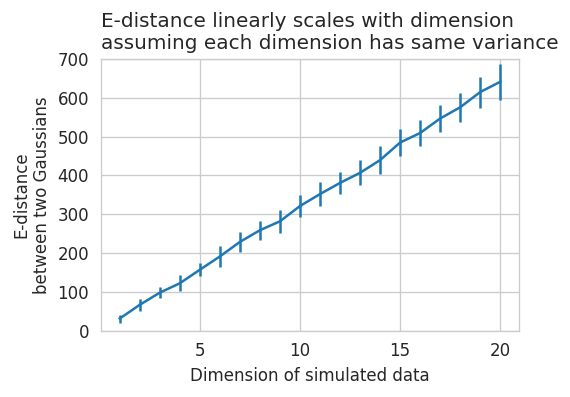

In [9]:
# since PCA will try to represent to overall variance in the data, this is not bad at all!
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(4.5,3), dpi=120)
ax.errorbar(np.arange(1,21), df.groupby('dimension').mean().edistance, yerr=df.groupby('dimension').std().edistance)
ax.set_xlabel('Dimension of simulated data')
ax.set_ylabel('E-distance\nbetween two Gaussians')
ax.set_title('E-distance linearly scales with dimension\nassuming each dimension has same variance', fontsize=12, ha='left', loc='left')
ax.set_ylim(0,700)
pl.savefig(figure_path / 'SuppFig_Simulation_dimension_no_impact.pdf', bbox_inches='tight')
pl.show()

# Convergence speed of E-distance with sample size depends on variance

## corrected

In [15]:
N = [2,5,20,50,200,500,2000]
mu = (2, -2)
S_low = (1,3)
S_high = (3,5)
df_low = simul(mu=mu, S=S_low, D=30, N=N, iterations=50, correction_factor=True)
df_high = simul(mu=mu, S=S_high, D=30, N=N, iterations=50, correction_factor=True)
df_low_ = simul(mu=mu, S=S_low, D=30, N=N, iterations=50, correction_factor=False)
df_high_ = simul(mu=mu, S=S_high, D=30, N=N, iterations=50, correction_factor=False)

100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


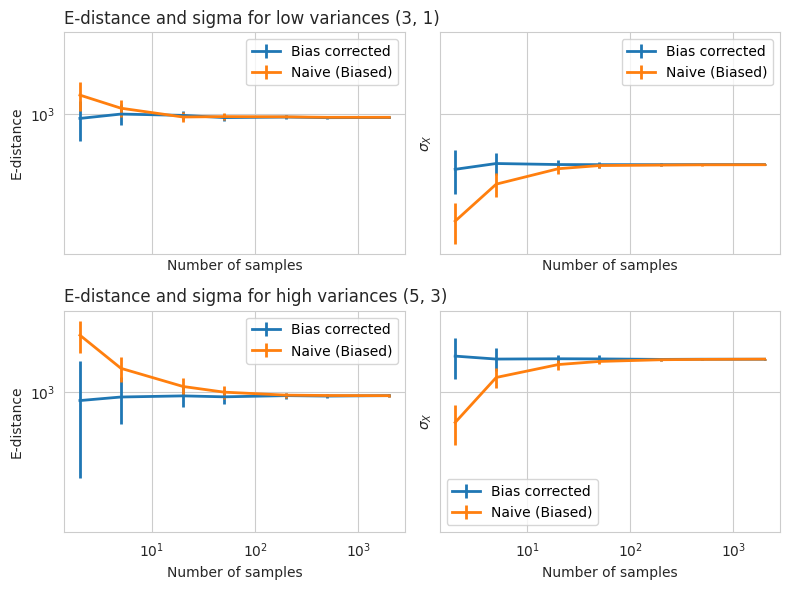

In [49]:
keys = ['edistance', 'sigma_x']
with sns.axes_style('whitegrid'):
    fig, axss = pl.subplots(2, len(keys), figsize=(4*len(keys), 3*2), dpi=100, sharex=True, sharey=True)

for axs, df, df_ in zip(axss, [df_low, df_high], [df_low_, df_high_]):
    for ax, key in zip(axs, keys):
        ax.errorbar(N, df.groupby('sample_size').mean()[key], 
                    yerr=df.groupby('sample_size').std()[key], 
                    label=f'Bias corrected', linewidth=2)
        ax.errorbar(N, df_.groupby('sample_size').mean()[key], 
                    yerr=df_.groupby('sample_size').std()[key], 
                    label=f'Naive (Biased)', linewidth=2)
        ax.set_xlabel('Number of samples')
        ax.set_ylabel('E-distance' if key=='edistance' else r'$\sigma_X$')
        ax.set_title('')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.legend()
axss[0,0].set_title(f'E-distance and sigma for low variances {S_low}', loc='left', ha='left')
axss[1,0].set_title(f'E-distance and sigma for high variances {S_high}', loc='left', ha='left')
pl.tight_layout()
pl.savefig(figure_path / 'SuppFig_Simulation_bias.pdf', bbox_inches='tight')
pl.show()

# Including PCA

In [50]:
N = [2,5,20,50,200,500,2000]
mu = (2, -2)
S_low = (1,3)
S_high = (3,5)
df_low = simul(mu=mu, S=S_low, D=30, N=N, iterations=50, correction_factor=True, pca=True)
df_high = simul(mu=mu, S=S_high, D=30, N=N, iterations=50, correction_factor=True, pca=True)
df_low_ = simul(mu=mu, S=S_low, D=30, N=N, iterations=50, correction_factor=False, pca=True)
df_high_ = simul(mu=mu, S=S_high, D=30, N=N, iterations=50, correction_factor=False, pca=True)

100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


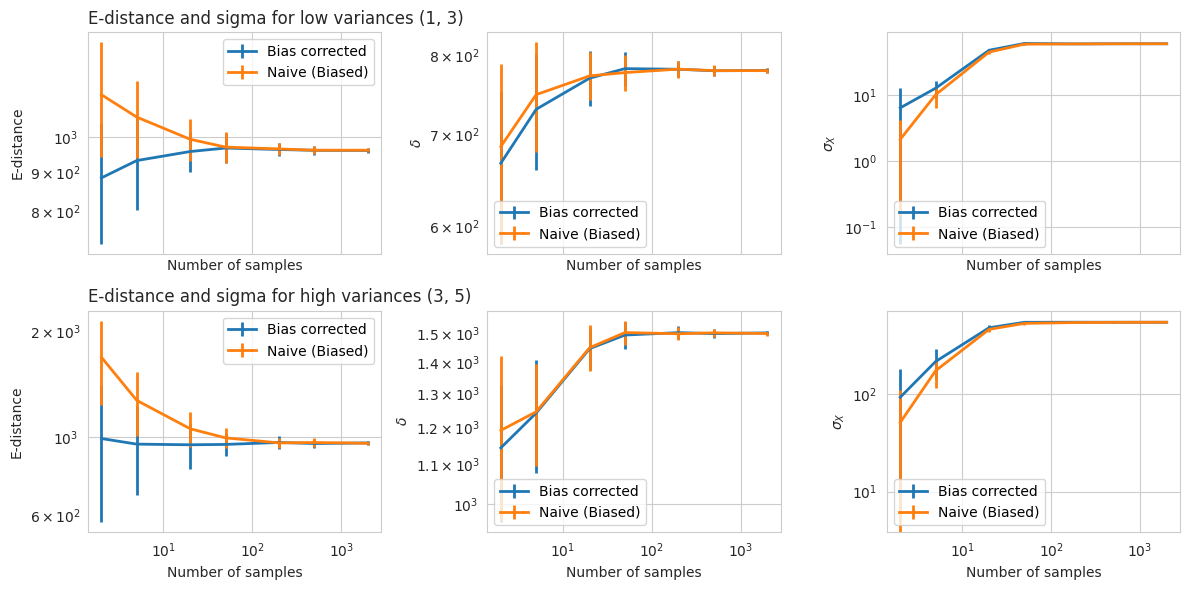

In [55]:
keys = ['edistance', 'delta', 'sigma_x']
with sns.axes_style('whitegrid'):
    fig, axss = pl.subplots(2, len(keys), figsize=(4*len(keys), 3*2), dpi=100, sharex=True, sharey=False)

for axs, df, df_ in zip(axss, [df_low, df_high], [df_low_, df_high_]):
    for ax, key in zip(axs, keys):
        ax.errorbar(N, df.groupby('sample_size').mean()[key], 
                    yerr=df.groupby('sample_size').std()[key], 
                    label=f'Bias corrected', linewidth=2)
        ax.errorbar(N, df_.groupby('sample_size').mean()[key], 
                    yerr=df_.groupby('sample_size').std()[key], 
                    label=f'Naive (Biased)', linewidth=2)
        ax.set_xlabel('Number of samples')
        ax.set_ylabel('E-distance' if key=='edistance' else r'$\delta$' if key=='delta' else r'$\sigma_X$')
        ax.set_title('')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.legend()
axss[0,0].set_title(f'E-distance and sigma for low variances {S_low}', loc='left', ha='left')
axss[1,0].set_title(f'E-distance and sigma for high variances {S_high}', loc='left', ha='left')
pl.tight_layout()
pl.savefig(figure_path / 'SuppFig_Simulation_bias_pca.pdf', bbox_inches='tight')
pl.show()